In [3]:
import pandas as pd
import datetime

In [30]:
df = pd.read_csv(r'C:\Users\USER\Desktop\AQA_data\AAPL_1min_sample_firstratedata\AAPL_1min_firstratedata.csv')

Data preprocessing

In [31]:
df['price'] = (df['high'] + df['low'])/2

In [12]:
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Extract only the time part
df["time"] = df["timestamp"].dt.time

In [33]:
df = df[(df["time"] >= datetime.time(9, 30)) & (df["time"] <= datetime.time(16, 0))]

In [36]:
def daily_cumulative(df, field):
    # Get the current date
    last_date = None
    df[f'cumulative_{field}'] = df[field]
    for index, row in df.iterrows():
        current_date = row['timestamp'].date()
        if last_date == current_date:
            df.at[index, f'cumulative_{field}'] = df.at[index - 1, f'cumulative_{field}'] + row[field]
        else:
            last_date = current_date
            df.at[index, f'cumulative_{field}'] = row[field]
    return df[f'cumulative_{field}']

def get_vwap(df):
    cum_volume = daily_cumulative(df, 'volume')
    df['turnover'] = df['price'] * df['volume']
    cum_turnover = daily_cumulative(df, 'turnover')
    vwap = (cum_turnover / cum_volume).fillna(0)
    return vwap

In [37]:
df['vwap'] = get_vwap(df)

In [38]:
df

,timestamp,open,high,low,close,volume,price,time,cumulative_volume,turnover,cumulative_turnover,vwap
271,2022-09-30 09:30:00,141.210,141.6850,140.950,141.6808,1553146,141.3175,09:30:00,1553146,2.194867e+08,2.194867e+08,141.317500
272,2022-09-30 09:31:00,141.670,142.0650,141.620,142.0321,475394,141.8425,09:31:00,2028540,6.743107e+07,2.869178e+08,141.440535
273,2022-09-30 09:32:00,142.035,142.3856,142.020,142.2274,456415,142.2028,09:32:00,2484955,6.490349e+07,3.518213e+08,141.580541
274,2022-09-30 09:33:00,142.210,142.4900,142.150,142.4735,337576,142.3200,09:33:00,2822531,4.804382e+07,3.998651e+08,141.668981
275,2022-09-30 09:34:00,142.480,142.6000,142.200,142.2900,426136,142.4000,09:34:00,3248667,6.068177e+07,4.605469e+08,141.764871
...,...,...,...,...,...,...,...,...,...,...,...,...
193707,2023-09-29 15:56:00,170.960,170.9900,170.760,170.9700,362510,170.8750,15:56:00,31380758,6.194390e+07,5.389378e+09,171.741479
193708,2023-09-29 15:57:00,170.962,171.2500,170.962,171.2300,395283,171.1060,15:57:00,31776041,6.763529e+07,5.457013e+09,171.733574
193709,2023-09-29 15:58:00,171.230,171.2600,171.140,171.1900,334892,171.2000,15:58:00,32110933,5.733351e+07,5.514347e+09,171.728010
193710,2023-09-29 15:59:00,171.190,171.3700,171.080,171.2200,948238,171.2250,15:59:00,33059171,1.623621e+08,5.676709e+09,171.713582


In [40]:
df.to_csv('AAPL_1min_firstratedata_with_vwap.csv', index=False)

VWAP algorithm

In [4]:
df= pd.read_csv('AAPL_1min_firstratedata_with_vwap.csv')

In [7]:
import statsmodels.api as sm
import statsmodels.tsa as tsa
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

In [5]:
train_size = int(len(df) * 0.75)
print("train data statistics:")
print(df["vwap"][:train_size].mean())
print(df["vwap"][:train_size].std())
print("test data statistics:")
print(df["vwap"][train_size:].mean())
print(df["vwap"][train_size:].std())

train data statistics:
154.63596136505825
16.115397352551113
test data statistics:
183.52868731842898
7.939116265770004


In [52]:
time_series= df["vwap"]

In [8]:

result = adfuller(df['vwap'][:train_size])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: 0.5399782061837372
p-value: 0.986038862886904


In [9]:
result = adfuller(df['vwap'][train_size:])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -0.7950733946065844
p-value: 0.8205649388133802


In [10]:
def daily_diff(df):
    last_date = None
    for index, row in df.iterrows():
        current_date = row['timestamp'].date()
        if last_date == current_date:
            df.at[index, f'vwap_diff'] = row["vwap"] - df.at[index - 1, "vwap"]
        else:
            last_date = current_date
            df.at[index, f'vwap_diff'] = 0
    return df[f'vwap_diff']


In [14]:
stock_data_diff = daily_diff(df)
result = adfuller(stock_data_diff[:train_size])
print('ADF Statistic:', result[0])
print('p-value:', result[1])



ADF Statistic: -31.07828620990513
p-value: 0.0


In [15]:
result = adfuller(df["vwap_diff"][train_size:])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -20.11820929995037
p-value: 0.0


In [129]:
stock_data_diff = stock_data_diff.reset_index(drop=True)

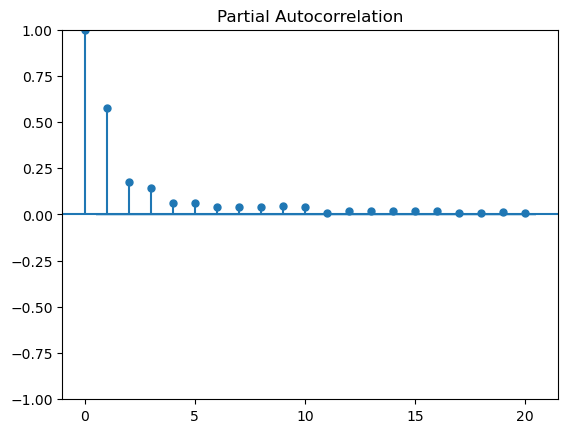

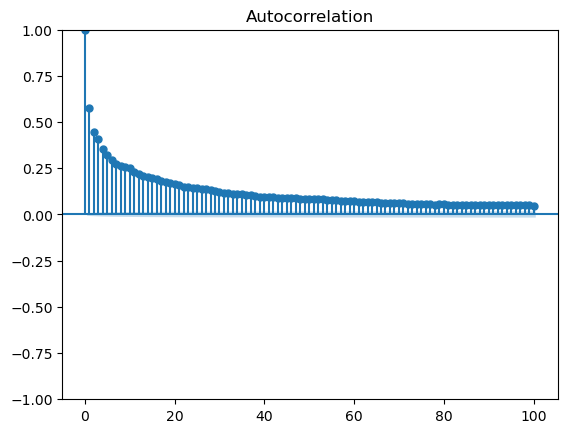

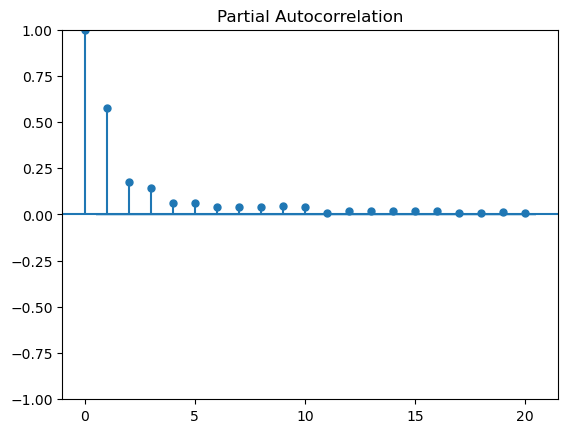

In [18]:
plot_acf(stock_data_diff[:train_size], lags=100)
plot_pacf(stock_data_diff[:train_size], lags=20)

In [19]:
train_size = int(len(stock_data_diff)* 0.75)
model = ARIMA(stock_data_diff[:train_size], order=(10, 0, 0))
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              vwap_diff   No. Observations:                73500
Model:                ARIMA(10, 0, 0)   Log Likelihood              227293.334
Date:                Sun, 31 Aug 2025   AIC                        -454562.667
Time:                        23:25:51   BIC                        -454452.207
Sample:                             0   HQIC                       -454528.675
                              - 73500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.285      0.022    6.55e-05       0.001
ar.L1          0.4242      0.000   1532.777      0.000       0.424       0.425
ar.L2          0.0882      0.001    153.015      0.0

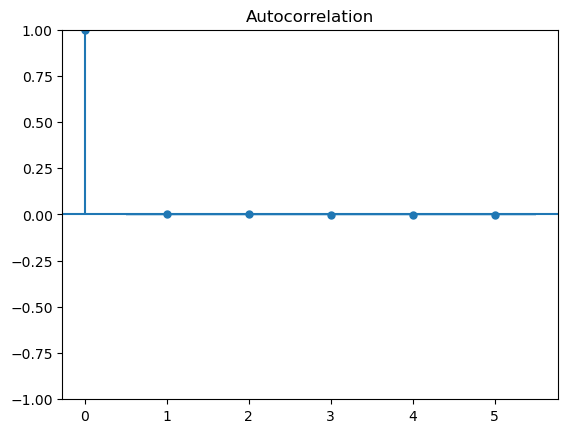

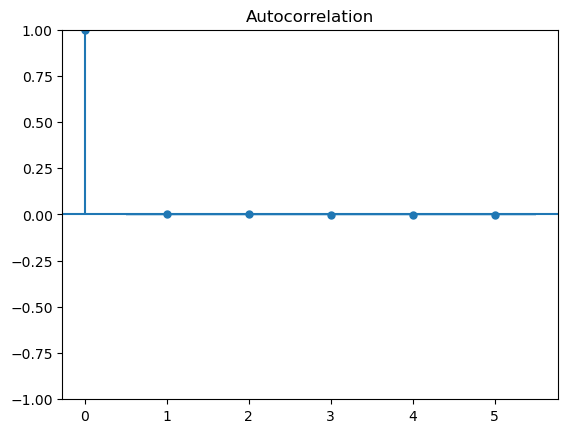

In [170]:
residuals = model_fit.resid
plot_acf(residuals, lags=5)

This suggests that the residuals behave like white noise—no autocorrelation remains.

Evaluation

In sample predictions

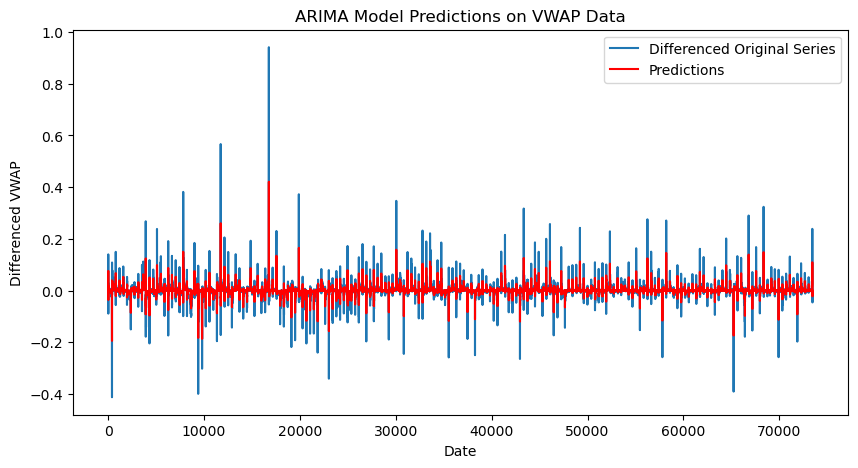

In [173]:
predictions = model_fit.predict(start=0, end=train_size-1)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(stock_data_diff[:train_size], label='Differenced Original Series')
plt.plot(predictions, label='Predictions', color='red')
plt.legend()
plt.title('ARIMA Model Predictions on VWAP Data')
plt.xlabel('Date')
plt.ylabel('Differenced VWAP')
plt.show()

In [175]:
train_data = df[:train_size].reset_index(drop=True)
test_data = df[train_size:].reset_index(drop=True)

In [176]:
last_date = None
last_vwap_forecast = None

for index, row in train_data.iterrows():
    current_date = row['timestamp'].date()
    if last_date == current_date:
        train_data.at[index, "vwap_prediction"]= last_vwap_forecast + predictions[index]
    elif index >0:
        train_data.at[index, "vwap_prediction"]= train_data.at[index-1, "vwap"] #do not use current data to trade
        last_date = current_date
        last_vwap_forecast = train_data.at[index, "vwap_prediction"]
    else:
        train_data.at[index, "vwap_prediction"]= train_data.at[index, "vwap"]
        last_date = current_date
        last_vwap_forecast = train_data.at[index, "vwap_prediction"]



In [177]:
MAPE= (np.abs(train_data["vwap"]-train_data["vwap_prediction"])/ np.abs(train_data["vwap"])).mean()*100
print(f"Mean Absolute Percentage Error (MAPE) on training set: {MAPE:.2f}%")

Mean Absolute Percentage Error (MAPE) on training set: 1.08%


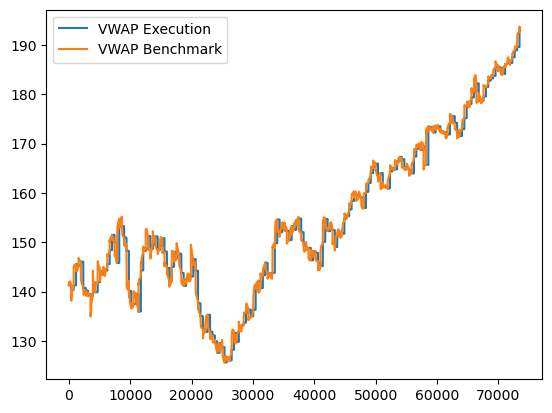

In [178]:
plt.plot(train_data["vwap_prediction"].values, label='VWAP Execution')
plt.plot(train_data['vwap'].values, label='VWAP Benchmark')
plt.legend()
plt.show()

Out of sample predictions

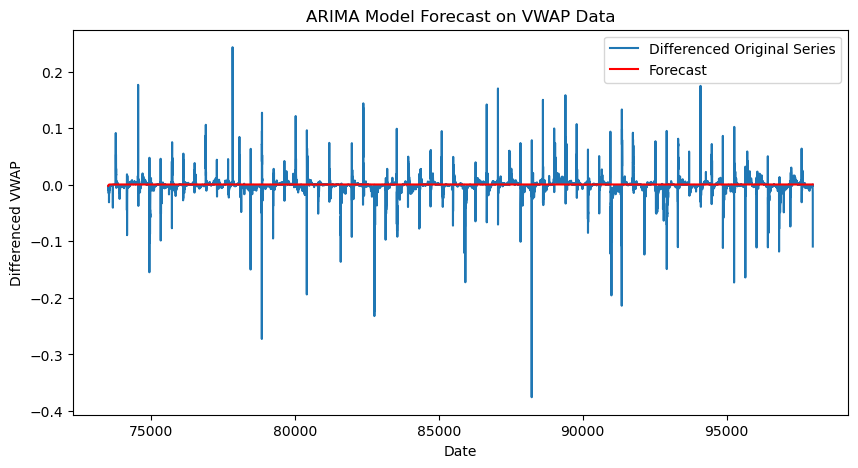

In [179]:
steps = len(df) - train_size
forecast = model_fit.forecast(steps=steps)
plt.figure(figsize=(10, 5))
plt.plot(stock_data_diff[train_size:], label='Differenced Original Series')
plt.plot(forecast, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Model Forecast on VWAP Data')
plt.xlabel('Date')
plt.ylabel('Differenced VWAP')
plt.show()


In [182]:
for index, row in test_data.iterrows():
    current_date = row['timestamp'].date()
    if last_date == current_date:
        test_data.at[index, "vwap_prediction"]= last_vwap_forecast + predictions[index]
    elif index >0:
        test_data.at[index, "vwap_prediction"]= test_data.at[index-1, "vwap"] #do not use current data to trade
        last_date = current_date
        last_vwap_forecast = test_data.at[index, "vwap_prediction"]
    else:
        test_data.at[index, "vwap_prediction"]= test_data.at[index, "vwap"]
        last_date = current_date
        last_vwap_forecast = test_data.at[index, "vwap_prediction"]



In [183]:
MAPE= (np.abs(test_data["vwap"]-test_data["vwap_prediction"])/ np.abs(test_data["vwap"])).mean()*100
print(f"Mean Absolute Percentage Error (MAPE) on test set: {MAPE:.2f}%")

Mean Absolute Percentage Error (MAPE) on test set: 0.78%


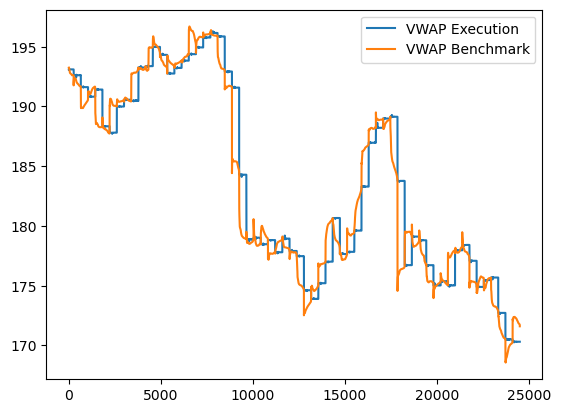

In [184]:
plt.plot(test_data["vwap_prediction"].values, label='VWAP Execution')
plt.plot(test_data['vwap'].values, label='VWAP Benchmark')
plt.legend()
plt.show()